# Split Titanic data upfront - A simple attempt for separate predictions


---

The Age-feature in the Titanic data is not defined for many passengers. Several good Kaggle notebooks do feature engineering to come up with replacements of the missing age data (e.g. [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook)).

I was wondering if it would be possible to just .... 
1. ** separate the training and test data ** into two buckets (Age defined vs. Age NaN), 
2. do **predictions separately**, and 
3. finally, ** concatenate the results**.


Additionally, the notebook includes basic hyperparameter tuning for RandomForest and AdaBoost.

## Overview:

- Import modules, read data and display some data
- Prepare subset of training and test data without any NaN in Age
- Predict 'Survived' for passengers data with Age
 - Grid search and fit with Random Forest Classifier
 - Grid search and fit with AdaBoost Classifier
 - Predict based on better algorithm and score
- Predict 'Survived' with Random Forest Classifier for passengers data without Age
- Concatenate predictions
- Summary



### Import modules, read data and display some data


As usual, import modules, read data and display some data

In [1]:
# data processing
import numpy as np
import pandas as pd 


import warnings
warnings.filterwarnings('ignore')

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold



# some configuratin flags and variables
verbose = 1 # Use in classifier
quick_run = True # if set to True, use only few variabales during hyperparameter tuning
n_jobs = -1

# Input files
file_train='../input/train.csv'
file_test='../input/test.csv'

# define random seed for reproducibility
seed = 69
np.random.seed(seed)

# read training and test data
train_df = pd.read_csv(file_train,index_col='PassengerId')
test_df = pd.read_csv(file_test,index_col='PassengerId')


#### Brief data preview:

In [2]:
# Show the columns
train_df.columns.values

array(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [3]:
# Show the shape
train_df.shape

(891, 11)

In [4]:
# preview the training data
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Show that there is NaN data (Age,Fare Embarked), that needs to be handled.
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

#### A function for simple data cleansing without the Age features
- Drop unwanted features ['Name', 'Ticket', 'Cabin']
- Fill missing data: Fare with the mean, Embarked with most frequent value
- Convert categorical features into numeric
- Convert Embarked to one-hot
- Note, missing data of the Age features is not filled.

In [7]:
def prep_data(df):
    # Drop unwanted features
    df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)
    
    # Fill missing data:  Fare with the mean, Embarked with most frequent value
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    
    # Convert categorical  features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
      
    # Convert Embarked to one-hot
    enbarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = df.drop('Embarked', axis=1)
    df = df.join(enbarked_one_hot)

    return df


### Prepare subset of training and test data without any NaN in Age

Prepare training data without any NaN in Age (**train_df_age_no_nan**). 
Show that there isn't any null data

In [8]:
train_df = prep_data(train_df)
train_df_age_no_nan = train_df[train_df['Age'].notnull()]
print("Training data without any NaN in Age:\n", train_df_age_no_nan.isnull().sum())

Training data without any NaN in Age:
 Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [9]:
train_df_age_no_nan.shape

(714, 10)

**Visualise feature correlation with a heatmap**

As expected, only the Gender is correlated to 'Survived'

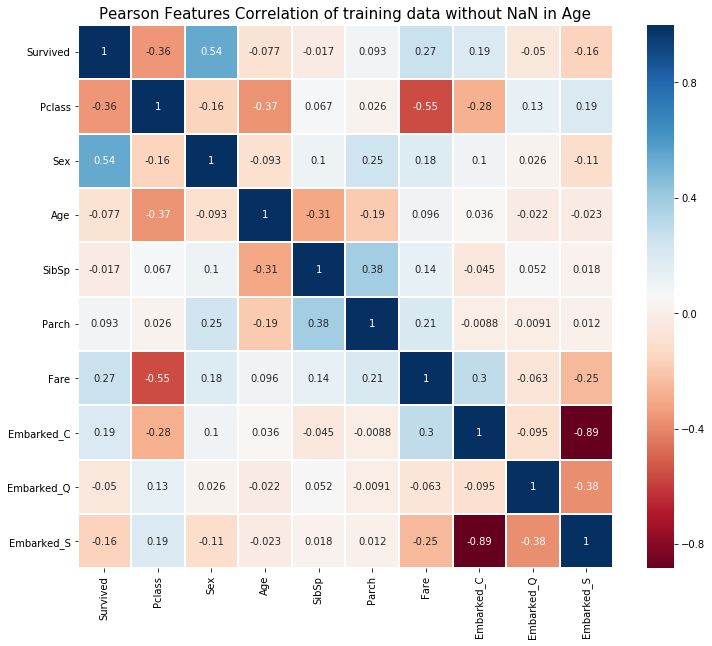

In [10]:
cmap = plt.cm.RdBu
corr = train_df_age_no_nan.corr()
plt.figure(figsize=(12,10))
plt.title('Pearson Features Correlation of training data without NaN in Age', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

** Show pairplots to visualize the distribution of data across features **

Further drill down could be helpfull. There are several Kaggel notebooks showing in-depth visualisations, data exploration and wrangling on the Titanic data:
- [In-Depth Visualisations - Simple Methods](https://www.kaggle.com/jkokatjuhha/in-depth-visualisations-simple-methods)
- [Titanic Data Exploration Starter](https://www.kaggle.com/neviadomski/titanic-data-exploration-starter)
- [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook)


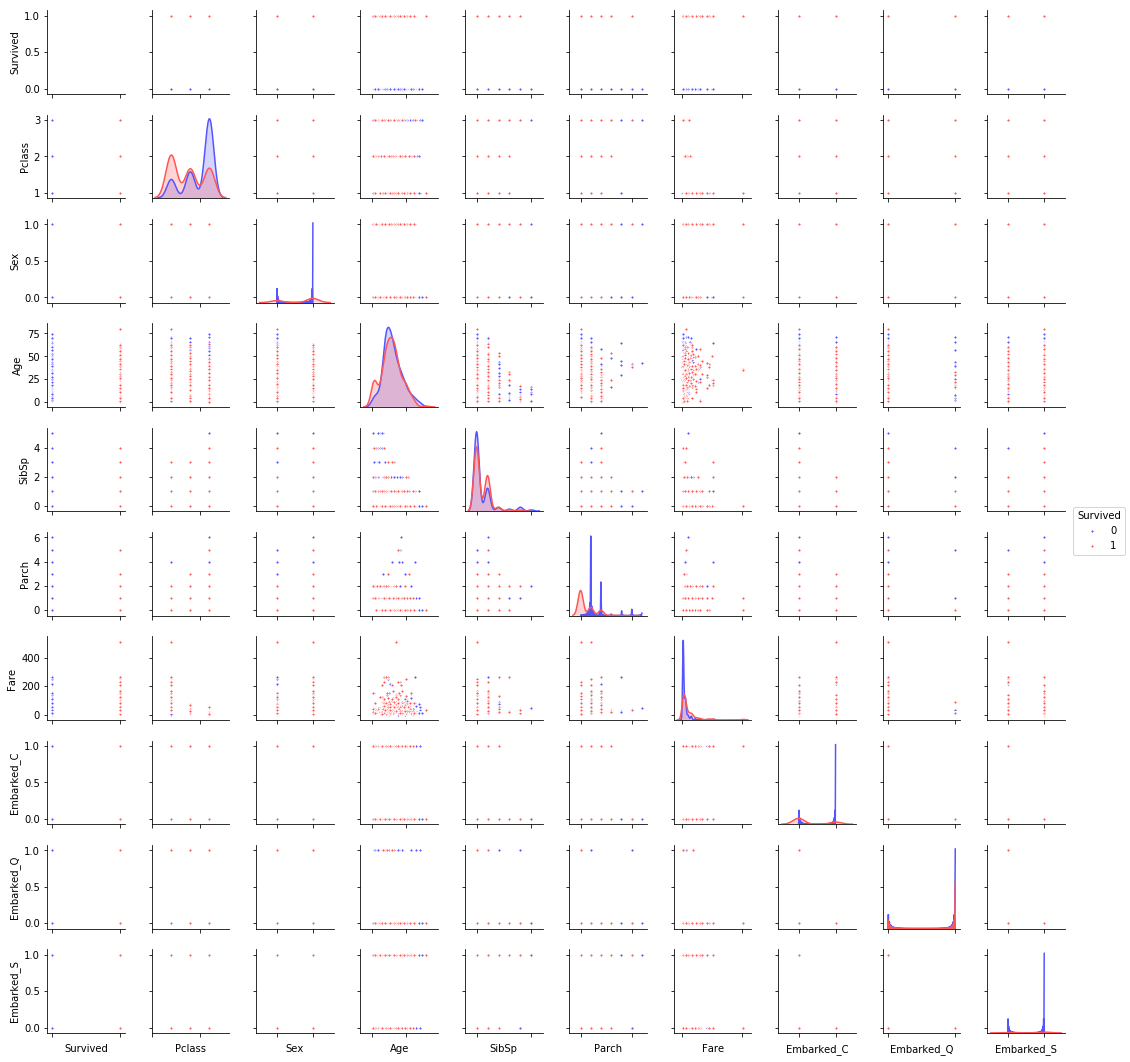

In [11]:
g = sns.pairplot(train_df_age_no_nan, hue='Survived', palette = 'seismic',size=1.5,diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

Prepare test data without any NaN in Age (**test_df_age_no_nan**). 

In [12]:
test_df = prep_data(test_df)
test_df_age_no_nan = test_df[test_df['Age'].notnull()]
print("Test data without any NaN in Age:\n", test_df_age_no_nan.isnull().sum())

Test data without any NaN in Age:
 Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [13]:
test_df_age_no_nan.shape

(332, 9)

### Predict 'Survived' for passengers data with Age

Split training data into input X and output Y

In [14]:
# X contains all columns except 'Survived'  
X = train_df_age_no_nan.drop(['Survived'], axis=1).values.astype(float)

# Y is just the 'Survived' column
Y = train_df_age_no_nan['Survived'].values

#### Grid search and fit with Random Forest Classifier

In [15]:
kfold = KFold(n_splits=10, random_state=seed)

if quick_run:
    rf_parameters = {"max_depth": [4,8]
                ,"min_samples_split" :[2,6]
                ,"n_estimators" : [100]
                ,"min_samples_leaf": [1,2]
                ,"max_features": [6,"sqrt"]
                ,"criterion": ['gini']}       
else:
    rf_parameters = {"max_depth": [2,4,6,8,12]
                ,"min_samples_split" :[2,3,5,8]
                ,"n_estimators" : [50, 100,200]
                ,"min_samples_leaf": [2,3,5]
                ,"max_features": [4,6,"sqrt"]
                ,"criterion": ['gini','entropy']}

print('** GridSearchCV RF ...') 
rf_clf = RandomForestClassifier()
rf_grid = GridSearchCV(rf_clf,rf_parameters, n_jobs = n_jobs, verbose = verbose, cv = 10)
rf_grid.fit(X,Y)

print('Best score RF: {}'.format(rf_grid.best_score_))
print('Best parameters RF: {}'.format(rf_grid.best_params_))

rf_clf = RandomForestClassifier(**rf_grid.best_params_)
rf_clf.fit(X,Y)

** GridSearchCV RF ...
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.0s finished


Best score RF: 0.8263305322128851
Best parameters RF: {'criterion': 'gini', 'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Grid search and fit with AdaBoost Classifier

In [16]:
if quick_run:
    ab_parameters = {'n_estimators':[50,100,200,300],
                  'learning_rate':[0.1,0.5,1.0,2.0]}
else:
    ab_parameters = {'n_estimators':[50,100],
                  'learning_rate':[0.5,1.0]}
    
print('** GridSearchCV AB ...') 
ab_clf = AdaBoostClassifier()
ab_grid = GridSearchCV(ab_clf,ab_parameters, n_jobs = n_jobs, verbose = verbose, cv = 10)
ab_grid.fit(X,Y)

print('Best score AB: {}'.format(ab_grid.best_score_))
print('Best parameters AB: {}'.format(ab_grid.best_params_))

ab_clf = AdaBoostClassifier(**ab_grid.best_params_)
ab_clf.fit(X,Y)

** GridSearchCV AB ...
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 137 out of 160 | elapsed:    5.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.2s finished


Best score AB: 0.8109243697478992
Best parameters AB: {'learning_rate': 1.0, 'n_estimators': 200}


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)

#### Predict based on better algorithm and score

In [17]:
# Create X_test
X_test = test_df_age_no_nan.values.astype(float)


# Predict 'Survived' for Age no NaN
if ( rf_grid.best_score_ > ab_grid.best_score_ ) :
    print('** Predict Survived for data with age using RF {}'.format(rf_grid.best_params_))
    prediction_age_no_nan = rf_clf.predict(X_test)
else:
    print('** Predict Survived for data with age using AB {}'.format(ab_grid.best_params_))
    prediction_age_no_nan = ab_clf.predict(X_test)


subm_no_nan = pd.DataFrame({
    'PassengerId': test_df_age_no_nan.index,
    'Survived': prediction_age_no_nan,
})
    
test_df_age_nan = test_df[test_df['Age'].isnull()]

** Predict Survived for data with age using RF {'criterion': 'gini', 'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### Predict 'Survived' for passengers data without Age

#### Grid search,  fit and predict with Random Forest Classifier

In [18]:
# Split training data into input X and output Y

train_df_age_nan = train_df[train_df['Age'].isnull()]

# X contains all columns except Age and 'Survived'  
X = train_df.drop(['Age','Survived'], axis=1).values.astype(float)

# Y is just the 'Survived' column
Y = train_df['Survived'].values


kfold = KFold(n_splits=10, random_state=seed)

print('** GridSearchCV (no Age) RF ...') 
rf_clf = RandomForestClassifier()
rf_grid = GridSearchCV(rf_clf,rf_parameters, n_jobs = n_jobs, verbose = verbose, cv = 10)
rf_grid.fit(X,Y)

print('Best score (no Age) RF: {}'.format(rf_grid.best_score_))
print('Best parameters (no Age) RF: {}'.format(rf_grid.best_params_))


rf_clf = RandomForestClassifier(**rf_grid.best_params_)
rf_clf.fit(X,Y)

# Predict test data with Age == NaN
X_test_age_nan = test_df_age_nan.drop(['Age'], axis=1).values.astype(float)

# Predict 'Survived'
prediction_age_nan = rf_grid.predict(X_test_age_nan)   

subm_nan = pd.DataFrame({
    'PassengerId': test_df_age_nan.index,
    'Survived': prediction_age_nan
})

** GridSearchCV (no Age) RF ...
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.8s finished


Best score (no Age) RF: 0.8170594837261503
Best parameters (no Age) RF: {'criterion': 'gini', 'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}


### Concatenate predictions

In [19]:
# stack the DataFrames on top of each other
submission = pd.concat([subm_no_nan, subm_nan], axis=0)

submission.sort_values('PassengerId', inplace=True)    
submission.to_csv('submission-splitt-input.csv', index=False)

## Summary
The score is not really great (~0.76) but comparable to many other simple approaches. My experiment illustrated that splitting the test and training data upfront due to data quality issues could be a reasonable approach.


Your feedback and suggestions are very welcome.